# Phần 1 : Giới thiệu Project : 
Titanic Survival Prediction 🚢⚓
Dự án này sử dụng dữ liệu Titanic để dự đoán khả năng sống sót của hành khách.  
Mục tiêu: Xây dựng mô hình Machine Learning phân loại **Survived (1) hoặc Not Survived (0)**.  


# Phần 2 : Import thư viện & đọc dữ liệu

In [158]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
import numpy as np
df = pd.read_csv("train.csv")

In [159]:
df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


# Phần 3 : Khám phá dữ liệu (EDA)


## 1)  Data Preprocessing : Tiền xử lý dữ liệu 
#### a) Loại bỏ Features không predictive

In [160]:
# PassengerId ,Name và Ticket không thể đóng góp gì trong việc dự đoán Death Rate nên ta loại bỏ 
drop_cols = ['PassengerId','Name','Ticket']
df = df.drop(columns=drop_cols)

#### b) Xóa Missing value 


In [161]:
# Kiểm tra số lượng Missing values 
df.isnull().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [162]:
# Loại bỏ cột có quá nhiều misisng value : Cabin
drop_cols = ['Cabin']
df = df.drop(columns=drop_cols)

#### c) Thay thế Missing values 

In [163]:
# Xử lý Features có missing value
# Impute Age (numeric)
age_imputer = SimpleImputer(strategy="median")
df["Age"] = age_imputer.fit_transform(df[["Age"]])[:, 0]
# Impute Embarked (categorical)
embarked_imputer = SimpleImputer(strategy="most_frequent")
df["Embarked"] = embarked_imputer.fit_transform(df[["Embarked"]])[:, 0]

# Phần 4 : Feature Engineering  

#### Heat map : Kiểm tra mức độ tương quan của các Features 

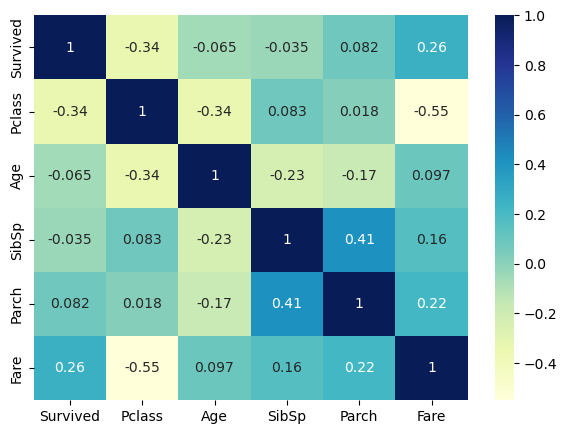

In [164]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(7,5))
sns.heatmap(df.select_dtypes(include=[float, int]).corr(), cmap="YlGnBu", annot=True)
plt.show()

Khi nhìn heatmap, ta thấy "Age", "SibSp", "Parch" |corr| với Survived khá thấp (gần 0) --> Máy học không hiệu quả

Ta nên tạo ra các features mới có tính phân biệt mạnh hơn, mang tính predictive hơn với target.



### a) Tạo thêm Feature mới  : Age Group 


Feature "Age" không mang tính tuyến tính với "Survived", do vậy ta tạo thêm feature mới "Age Group" 

"Age Group" mang tính phân biệt rõ hơn, mang tính predictive mạnh mẽ với "Survivied"

In [165]:
# Định nghĩa bins và labels
bins = [0, 5, 12, 18, 24, 35, 60, np.inf]
labels = ['Baby', 'Child', 'Teenager', 
          'Student', 'Young Adult', 'Adult', 'Senior']
# Tạo cột AgeGroup
df["AgeGroup"] = pd.cut(df["Age"], bins=bins, labels=labels)
# Hàm cut chia chia dữ liệu số liên tục (continuous) thành các nhóm rời rạc (bins),kết quả trả về là Series dạng category (mỗi giá trị thuộc một nhóm).

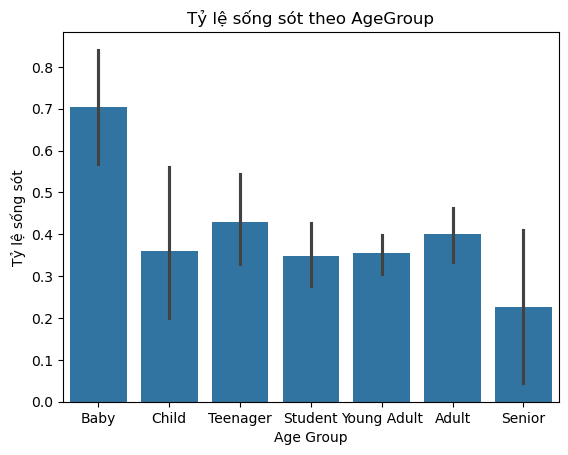

In [166]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.barplot(data=df, x="AgeGroup",y="Survived") 
plt.title("Tỷ lệ sống sót theo AgeGroup")
plt.ylabel("Tỷ lệ sống sót")
plt.xlabel("Age Group")
plt.show()

#### Nhận xét : Tỉ lệ sống sót đã mang tính phân biệt hơn với từng nhóm tuổi 

#### Encode AgeGroup 


In [167]:
age_mapping = {'Baby': 1, 'Child': 2, 'Teenager': 3,
               'Student': 4, 'Young Adult': 5, 'Adult': 6, 
               'Senior': 7}
df["AgeGroup"] = df["AgeGroup"].astype(str).map(age_mapping)

### b) Tạo thêm feature : "Family size " và "IsAlone"
- Tương tự, ta tạo thêm Family size, IsAlone

In [168]:
df["FamilySize"] = df["SibSp"] + df["Parch"]
df["IsAlone"] = (df["FamilySize"] == 0).astype(int)
# FamilySize = tổng số người trong gia đình cùng đi trong chuyến tàu 
# IsAlone = có đi một mình hay không (1: Alone / 2 : Not Alone ) 

### c) Vẽ Heat Map : Kiểm tra mức độ tương quan của các Features mới được tạo ra 

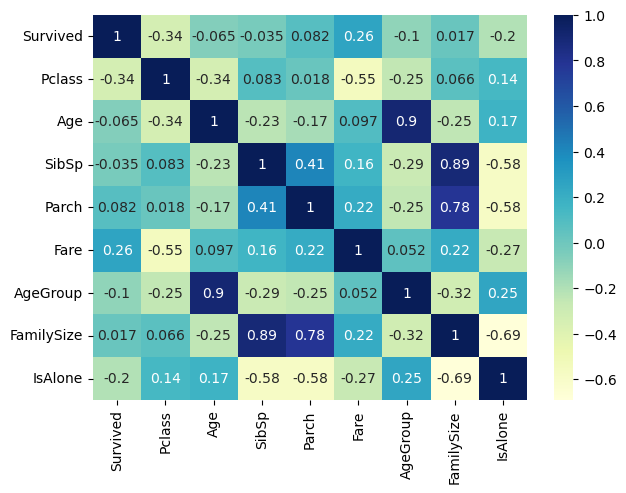

In [169]:
plt.figure(figsize=(7,5))
sns.heatmap(df.select_dtypes(include=[float, int]).corr(), cmap="YlGnBu", annot=True)
plt.show()

Nhận xét 1 : Các Feature mới được tạo ra : AgeGroup, IsAlone có tương quan lớn với Target

Nhận xét 2 : "FamilySize" và " IsAlone " có |corr| rất lớn với SibSp và Parch , còn Age Group có |corr| rất lớn với Age 

--> Nếu dùng Logistic Regression, thì ta nên drop cột SibSp và Parch và age để tránh multicollinearity (đa cộng tuyến)

In [170]:
# Xóa cột nhằm tránh multicollinearity 
df.drop(["SibSp", "Parch", "Age"], axis=1, inplace=True)

# Phần 5 : Encode và Scale Features

In [171]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    891 non-null    int64  
 1   Pclass      891 non-null    int64  
 2   Sex         891 non-null    object 
 3   Fare        891 non-null    float64
 4   Embarked    891 non-null    object 
 5   AgeGroup    891 non-null    int64  
 6   FamilySize  891 non-null    int64  
 7   IsAlone     891 non-null    int64  
dtypes: float64(1), int64(5), object(2)
memory usage: 55.8+ KB
None


#### a) Encode 
Ta cần Encode Feature 'Sex' và 'Embarked'

In [172]:
# Sex là Feature có 2 label nên ta dùng pp map 
sex_mapping = {"male": 0, "female": 1}
df['Sex'] = df['Sex'].map(sex_mapping)  
# Embarked chỉ có 3 label nên ta cũng dùng pp map  
embarked_mapping = {"S": 1, "C": 2, "Q": 3}
df['Embarked'] = df['Embarked'].map(embarked_mapping)

#### b) Scale 
Ta cần Scale Feature "Fare" do nó quá lớn so với các dữ liệu còn lại

In [179]:
from sklearn.preprocessing import StandardScaler
# Lọc ra numeric liên tục (Age, Fare, FamilySize,…)
cols_to_scale = ["Fare"]
scaler = StandardScaler()
df[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])

# Phần 6 : Trainning Model 



In [175]:
from sklearn.model_selection import train_test_split

X = df.drop(['Survived'], axis=1)
y = df['Survived']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## a) Logistic Regression 

In [176]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
model = LogisticRegression(max_iter=1000, solver='lbfgs')
# max_iter=1000: tăng số vòng lặp để tránh lỗi hội tụ
model.fit(X_train, y_train)
# Dự đoán
y_pred = model.predict(X_test)
print("Accuracy :", accuracy_score(y_test, y_pred))
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy : 0.8044692737430168

Confusion matrix:
 [[91 14]
 [21 53]]


## b) Decision Tree 

In [177]:
from sklearn.tree import DecisionTreeClassifier

# Khởi tạo và train model
dt = DecisionTreeClassifier(max_depth=4, random_state=42)
dt.fit(X_train, y_train)

# Dự đoán
y_pred = dt.predict(X_test)
print("Accuracy :", accuracy_score(y_test, y_pred))
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy : 0.7988826815642458

Confusion matrix:
 [[96  9]
 [27 47]]


## c) Random Forest 

In [178]:
#Khởi tạo model Random Forest

rf = RandomForestClassifier(
    n_estimators=100,   # số lượng cây
    max_depth=4,    
    random_state=42
)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.8156424581005587

Confusion matrix:
 [[95 10]
 [23 51]]
